<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine Tuning

In [2]:
!nvidia-smi

Wed Jul 13 23:42:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##importing from github

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-13 23:44:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-13 23:44:04 (70.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



##importing from github file in google colab file structure

In [11]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

NameError: ignored

##Getting data

In [5]:
#Getting 10% training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-13 23:48:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   194MB/s    in 0.8s    

2022-07-13 23:48:40 (194 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [13]:
unzip_data("10_food_classes_10_percent.zip")

In [14]:
#Checking num images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [15]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [16]:
import tensorflow as tf
IMG_SIZE = (244,244)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
train_data_10_percent,
test_data

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [17]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [18]:
train_data_10_percent.take

<bound method DatasetV2.take of <BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>>

In [19]:
#example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.96752411e+02 2.01752411e+02 2.04752411e+02]
   [1.94216263e+02 1.99216263e+02 2.02216263e+02]
   [1.93082169e+02 1.98082169e+02 2.02082169e+02]
   ...
   [1.06533104e+02 9.15331039e+01 8.65331039e+01]
   [1.07650764e+02 9.26507645e+01 8.76507645e+01]
   [1.09752396e+02 9.17523956e+01 8.77523956e+01]]

  [[1.95326599e+02 2.00326599e+02 2.03326599e+02]
   [1.93057388e+02 1.98057388e+02 2.01057388e+02]
   [1.92483002e+02 1.97483002e+02 2.01483002e+02]
   ...
   [1.08638687e+02 9.36386871e+01 8.86386871e+01]
   [1.09228249e+02 9.42282486e+01 8.92282486e+01]
   [1.14939415e+02 9.69394150e+01 9.29394150e+01]]

  [[1.94606567e+02 1.99606567e+02 2.03606567e+02]
   [1.90343658e+02 1.95343658e+02 1.99343658e+02]
   [1.91935425e+02 1.96935425e+02 2.00935425e+02]
   ...
   [1.17060272e+02 1.02060272e+02 9.70602722e+01]
   [1.16981972e+02 1.01981972e+02 9.69819717e+01]
   [1.15679901e+02 9.76799011e+01 9.36799011e+01]]

  ...

  [[1.93402374e+02 1.78287842e+02 5.36314468e+01]
   [1

#Keras functional API

In [25]:
#Building transfer leanring model
#Funcitonal api gives more flexibility with our models
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#creating inputs for model
inputs = tf.keras.layers.Input(shape=(244,244,3), name="input_layer")

#If using ResNet50V2 you will need to normalize layers
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"Base model shape: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f"Shape after global avg pooling:{x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)


model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10percentfeatureextraction")]
                                )

Base model shape: (None, 7, 7, 1280)
Shape after global avg pooling:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10percentfeatureextraction/20220714-001906
Epoch 1/5
24/24 [==============================] - 11s 250ms/step - loss: 1.9333 - accuracy: 0.3813 - val_loss: 1.3824 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 5s 197ms/step - loss: 1.1783 - accuracy: 0.7267 - val_loss: 0.9227 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 5s 200ms/step - loss: 0.8469 - accuracy: 0.8053 - val_loss: 0.7689 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - 5s 198ms/step - loss: 0.6985 - accuracy: 0.8413 - val_loss: 0.6738 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 5s 198ms/step - loss: 0.6076 - accuracy: 0.8587 - val_loss: 0.5800 - val_accuracy: 0.8668


In [26]:
#evaluation
model_0.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6050 - accuracy: 0.8500


[0.6049846410751343, 0.8500000238418579]

In [29]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_5
1 rescaling_4
2 normalization_4
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [30]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

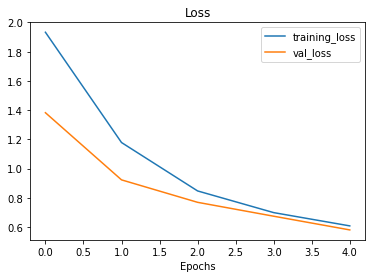

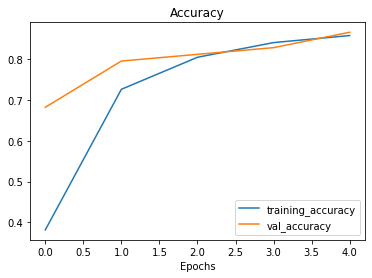

In [31]:
plot_loss_curves(history_10_percent)

#Getting feature vector from trainned model using Global average pooling layer

In [33]:
input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Tensor: {input_tensor}")

Random Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [35]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2d global average pooled tensor: {global_average_pooled_tensor}")

2d global average pooled tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [37]:
print(f"input tensor: {input_tensor.shape}")
print(f"global average tensor: {global_average_pooled_tensor.shape}")

input tensor: (1, 4, 4, 3)
global average tensor: (1, 3)


In [40]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>